In [1]:
from __future__ import division

from pylab import *
import scipy
import time
import utils
import hrr_utils
import RM_utils
import res_utils
import utilities.colormaps as colormaps
import random
import string
import pandas as pd

#import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from scipy import stats

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.family': 'serif', 'font.serif':['Computer Modern']})

In [2]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'
xticks = [k for k in range(0, len(alph), 3)]
xticklabels = [alph[i] for i in range(0, len(alph), 3)]
D = len(alph)

with open('data/8-letter-words.csv') as f:
    words8 = []
    for row in csv.reader(f, delimiter=',', quoting=csv.QUOTE_NONE):
        words8 += row

with open('data/4-letter-words.csv') as f:
    words4 = []
    for row in csv.reader(f, delimiter=',', quoting=csv.QUOTE_NONE):
        words4 += row

NameError: name 'csv' is not defined

In [214]:
def accuracy(pred, actual):
    acc = 0
    for i in range(len(pred)):
        if pred[i] == actual[i]:
            acc += 1
    return acc / float(len(pred))

def explain_away(bound_vec, states, coef_hists, state_length, letter_vecs, 
                 N, D, max_steps=500, conseq=100):
    th_vec = bound_vec.copy()
    conseq_preds = []
    
    convstep = -1
    nconvstep = -1

    convstep_pred = np.nan
    nconvstep_pred = np.nan

    for i in range(max_steps):

        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])
        
        for j in range(1, state_length-1):
            mxidx = np.argmax(np.abs(coef_hists[j-1][i,:]))
            states[j] *= np.sign(coef_hists[j-1][i, mxidx])
        ljds = []
        for j in range(1, state_length-1):
            if j == 1:
                ljds.append(
                    (np.roll(th_vec * states[0] * np.roll(states[2], 2), -1) +
                    th_vec * np.roll(states[2], 1) * np.roll(states[3], 2)) / 2
                )
            elif 1 < j < state_length-2:
                ljds.append(
                    (np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
                )
            else:
                ljds.append(
                    (np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2
                )

        for j in range(1, state_length-1):    
            states[j] = np.dot(letter_vecs.T, np.dot(ljds[j-1], letter_vecs.T)/N) + 1.0*states[j]
        
        bv = states[0] * np.roll(states[1],1) * np.roll(states[2],2)  
        for j in range(1, state_length-2):
            bv += states[j] * np.roll(states[j+1],1) * np.roll(states[j+2],2) 
         
        th_vec = bound_vec - bv
        pred, alphis = res_utils.spell(coef_hists)
        
        if convstep_pred is np.nan:
            if len(conseq_preds) == conseq and len( set( conseq_preds ) ) == 1:
                convstep = i
                convstep_pred = pred

            conseq_preds.append(pred)
            conseq_preds = conseq_preds[-conseq:]
        elif nconvstep_pred is np.nan:
            if len(conseq_preds) == conseq and \
            len( set( conseq_preds ) ) == 1 and \
            pred != convstep_pred:
                nconvstep = i
                nconvstep_pred = pred

            conseq_preds.append(pred)
            conseq_preds = conseq_preds[-conseq:]
            
    return states, coef_hists, convstep, convstep_pred, nconvstep, nconvstep_pred

def run(words, word_length=8, trials=50, N=1000, n_steps=500):
    # pred, convstep_pred, nconvstep_pred, word
    d = {'pred': [], 'convstep_pred': [], 'nconvstep_pred': [], 'word': [],
         'coef_hists': [], 'convstep': [], 'nconvstep': []
        }

    for trial in range(trials):
        for word in words:
            dic1 = 2 * (np.random.randn(D, N) < 0) - 1

            word_vec = RM_utils.ngram_encode_cl(word, dic1, alph)

            states, coef_hists = res_utils.initialize(dic1, N, D, word_length+2, n_steps)
            states, coef_hists, convstep, convstep_pred, nconvstep, nconvstep_pred = explain_away(
                word_vec, states, coef_hists, word_length+2, dic1, N, D, n_steps)

            pred, alphis = res_utils.spell(coef_hists)

            d['word'].append(word)
            d['pred'].append(pred)
            d['coef_hists'].append(coef_hists)
            d['convstep'].append(convstep)
            d['convstep_pred'].append(convstep_pred)
            d['nconvstep'].append(nconvstep)
            d['nconvstep_pred'].append(nconvstep_pred)
        #c.append([coef_hists, convstep, convstep_pred, nconvstep, nconvstep_pred, pred, word])
        #print (pred, convstep_pred, nconvstep_pred, word)
    return d
    
def check_wrong_switches(d):
    numitems = len(d['pred'])
    # switch from right to wrong answer
#     switches = [[] for i in range(4)]
    for i in range(numitems):
        if d['nconvstep_pred'][i] is np.nan:
            if d['pred'][i] != d['word'][i] and d['convstep_pred'][i] == d['word'][i]:
                print ('0', d['pred'][i], d['convstep_pred'][i],  d['nconvstep_pred'][i], d['word'][i] )
                return i
        elif d['convstep_pred'][i] == d['word'][i] and d['nconvstep_pred'][i] != d['word'][i]:
            print ('1', d['pred'][i], d['convstep_pred'][i],  d['nconvstep_pred'][i], d['word'][i] )
            return i
        elif d['convstep_pred'][i] == d['word'][i] and d['pred'][i] != d['word'][i]:
            print ('2', d['pred'][i], d['convstep_pred'][i],  d['nconvstep_pred'][i], d['word'][i] )
            return i
        elif d['nconvstep_pred'][i] == d['word'][i] and d['pred'][i] != d['word'][i]:
            print ('3', d['pred'][i], d['convstep_pred'][i],  d['nconvstep_pred'][i], d['word'][i] )
            return i
    return -1

def pop_dict(conds, d, ci, di):
    conds[ci]['word'].append(d['word'][di])
    conds[ci]['pred'].append(d['pred'][di])
    conds[ci]['convstep'].append(d['convstep'][di])
    conds[ci]['convstep_pred'].append(d['convstep_pred'][di])
    conds[ci]['nconvstep'].append(d['nconvstep'][di])
    conds[ci]['nconvstep_pred'].append(d['nconvstep_pred'][di])

    
def check_correct_switches(d):
    numitems = len(d['pred'])
    # switch from wrong to right answer
    conds = {}
    num_conds = 3
    coef_hists = []
    for i in range(num_conds):
        conds[i] = {'pred': [], 'convstep_pred': [], 'nconvstep_pred': [], 'word': [],
                    'convstep': [], 'nconvstep': []
        }
        coef_hists.append([])
        
    for i in range(numitems):
        #print (d['convstep_pred'][i], d['nconvstep_pred'][i], d['pred'][i], d['word'][i])
        if not d['nconvstep_pred'][i] is np.nan:
            #print ('not nan')
            if (d['convstep_pred'][i] != d['word'][i] and d['nconvstep_pred'][i] == d['word'][i]):
                pop_dict(conds, d, 0, i)
                coef_hists[0].append(d['coef_hists'][i])
            if (d['nconvstep_pred'][i] != d['word'][i] and d['pred'][i] == d['word'][i]):
                pop_dict(conds, d, 1, i)
                coef_hists[1].append(d['coef_hists'][i])
        if (d['convstep_pred'][i] != d['word'][i] and d['pred'][i] == d['word'][i]):
            #print ('nan')
            pop_dict(conds, d, 2, i)
            coef_hists[2].append(d['coef_hists'][i])
    return conds, coef_hists

def check_wrong(d):
    numitems = len(d['pred'])

    conds = {}
    coef_hists = []
    num_conds = 2
    for i in range(num_conds):
        conds[i] = {'pred': [], 'convstep_pred': [], 'nconvstep_pred': [], 'word': [],
                    'convstep': [], 'nconvstep': []
        }
        coef_hists.append([])
        
    for i in range(numitems):
        if d['convstep_pred'][i] != d['word'][i]:
            pop_dict(conds, d, 0, i)
            coef_hists[0].append(d['coef_hists'][i])
        if d['pred'][i] != d['word'][i]:
            pop_dict(conds, d, 1, i)
            coef_hists[1].append(d['coef_hists'][i])
    return conds, coef_hists
    
def check_correct(d):
    numitems = len(d['pred'])

    conds = {}
    coef_hists = []
    num_conds = 2
    for i in range(num_conds):
        conds[i] = {'pred': [], 'convstep_pred': [], 'nconvstep_pred': [], 'word': [],
                    'convstep': [], 'nconvstep': []
        }
        coef_hists.append([])
        
    for i in range(numitems):
        if d['convstep_pred'][i] == d['word'][i]:
            pop_dict(conds, d, 0, i)
            coef_hists[0].append(d['coef_hists'][i])
        if d['pred'][i] == d['word'][i]:
            pop_dict(conds, d, 1, i)
            coef_hists[1].append(d['coef_hists'][i])
    return conds, coef_hists
    

In [198]:
# 3
trials = 1

d = run(words8, 8, trials)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in m

In [199]:
correct_switches, cwcoef_hists = check_correct_switches(d)
wrongs, wcoef_hists = check_wrong(d) 
corrects, ccoef_hists = check_correct(d)

In [200]:
fname = ('data/switches-8-' + str(1000) + '-D=' + str(D))
np.savez(fname + '.npz', cwcoef_hists=cwcoef_hists, wcoef_hists=wcoef_hists, ccoef_hists=ccoef_hists, N=1000, D=D)


In [201]:
d8 = {'correct_switches': correct_switches, 'corrects': corrects, 'wrongs': wrongs}
df8 = pd.DataFrame(data=d8)
df8.to_csv(fname + '.csv', sep=',')

In [220]:
def resplot_im(coef_hists,
              title,
              nsteps,
              N):
    pred, alphis = res_utils.spell(coef_hists)
    rows = 1
    columns = len(coef_hists)

    fig = plt.figure(figsize=(10, 4))
    ax = columns * [0]
    
    x_idxs = list(np.arange(0, len(alph), 4))
    x_labels = np.array(list(alph))[x_idxs]  
        
    for j in range(columns):
        ax[j] = fig.add_subplot(rows, columns, j+1)

        a = np.sign(coef_hists[j][-1,alphis[j]])
        coef_hists[j][:,alphis[j]] *= a

        x_h = coef_hists[j][:,:]
        
        imh = ax[j].imshow(x_h, interpolation='none', aspect='auto', cmap=colormaps.viridis)
        
        if j == 0:
            ax[j].set_ylabel('Iterations')
        else: 
            ax[j].set_yticks([])
        ax[j].set_xticks(x_idxs)
        ax[j].set_xticklabels(x_labels)           
        ax[j].set_title(alph[alphis[j]])


#     colorbar(imh, ticks=[])

    fname = 'figures/res_im-'+title+'-'+pred+'-N='+str(N)+'-steps='+str(nsteps) +'-n' + time.strftime('%y%m%d')
    savefig(fname + '.png', format='png', transparent=True)
    savefig(fname + '.eps', format='eps', transparent=True)

    plt.tight_layout()

In [221]:
f = np.load('data/switches-4-1000-D=28.npz')

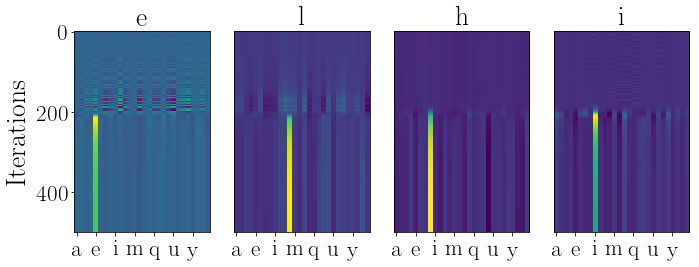

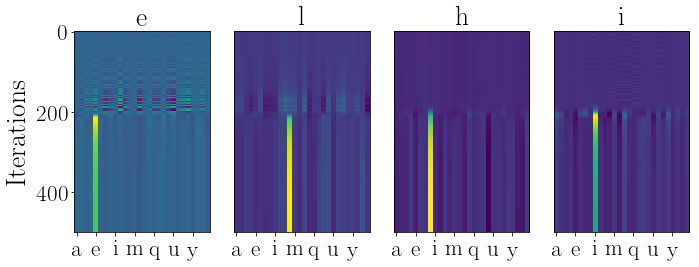

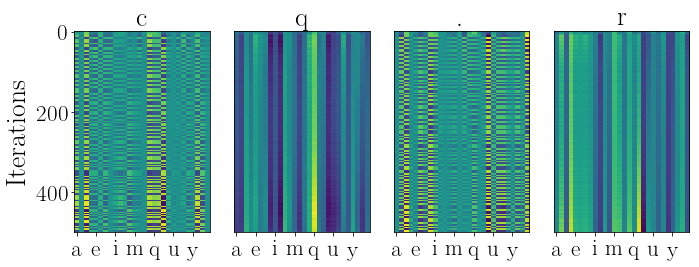

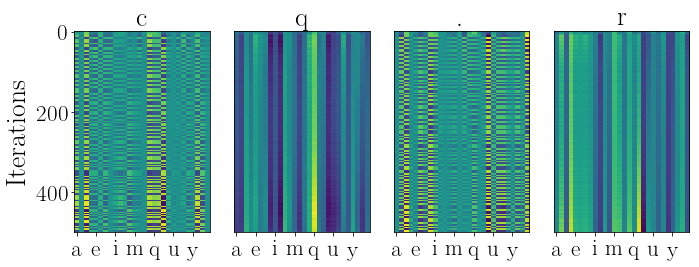

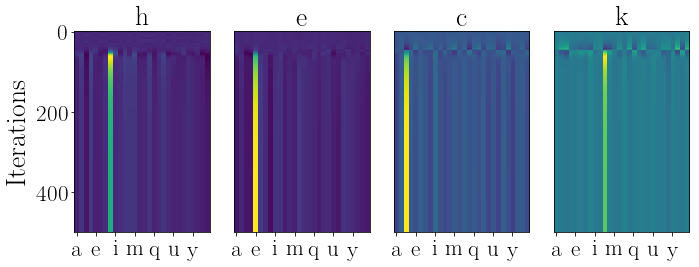

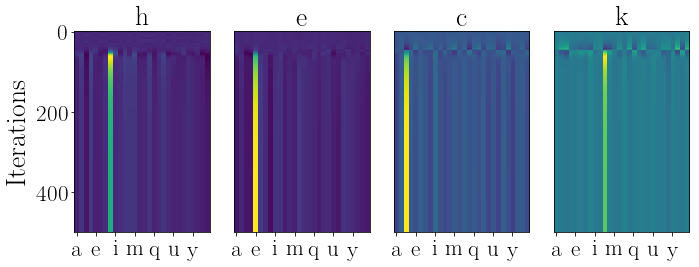

In [222]:
# correct_switches, cwcoef_hists = check_correct_switches(d)
# wrongs, wcoef_hists = check_wrong(d) 
# corrects, ccoef_hists = check_correct(d)
def plot(coef_hists, title):
    for i in range(len(coef_hists)):
        if len(coef_hists[i]) > 0:
            resplot_im(coef_hists[i][0], title, 500, 1000)
plot(f['cwcoef_hists'], 'correct_switch')
plot(f['wcoef_hists'], 'wrong')
plot(f['ccoef_hists'], 'correct')